## Game Modeling Code

- .venv (Python 3.10.13)

In [4]:
# !pip install optuna joblib nfl_data_py xgboost scikit-learn

In [76]:
import optuna
import joblib
import pandas as pd
import nfl_data_py as nfl
import xgboost
import numpy as np

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict

In [77]:
import sys
import importlib

if 'functions' in sys.modules:
    del sys.modules['functions']

sys.path.insert(0, '/Users/aidanbeilke/Desktop/Football Projects')

from functions import preprocess_data

In [78]:
check = preprocess_data(list(range(2000, 2025)))

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


## Feature Selection

In [137]:
check['ppg_diff'] = check['home_points'] - check['away_points']
check['exp_ppg_ppga_home'] = np.where(
    check['home_points_allowed'] == 0,
    np.nan,
    check['home_points'] / check['home_points_allowed']
)

check['exp_ppg_ppga_away'] = np.where(
    check['away_points_allowed'] == 0,
    np.nan,
    check['away_points'] / check['away_points_allowed']
)

check['epa_diff'] = check['home_epa_per_play'] - check['away_epa_per_play']
check['win_diff'] = check['home_team_wins'] - check['away_team_wins']
check['ppga_diff'] = check['home_points_allowed'] - check['away_points_allowed']

## Home Elo
check['home_epa_score'] = (
    (check['home_epa_per_play'] - check['home_epa_per_play'].mean()) /
    check['home_epa_per_play'].std()
)
check['home_point_score'] = (
     (check['home_points'] - check['home_points_allowed'] - 
      (check['home_points'] - check['home_points_allowed']).mean()) /
     (check['home_points'] - check['home_points_allowed']).std()
)

check['home_elo'] = check['home_epa_score'] + (check['home_point_score'] * 1.5)

## Away Elo
check['away_epa_score'] = (
     (check['away_epa_per_play'] - check['away_epa_per_play'].mean()) /
     check['away_epa_per_play'].std()
)
check['away_point_score'] = (
   (check['away_points'] - check['away_points_allowed'] - 
    (check['away_points'] - check['away_points_allowed']).mean()) /
    (check['away_points'] - check['away_points_allowed']).std()
)

check['away_elo'] = check['away_epa_score'] + (check['away_point_score'] * 1.5)

X = check[['home_points',
 'home_points_allowed',
 'home_air_yards',
 'home_passing_yards',
 'home_rushing_yards',
 'home_epa_per_play',
 'home_pass_attempt',
 'home_rush_attempt',
 'home_interception',
 'home_fumble_lost',
 'away_points',
 'away_points_allowed',
 'away_air_yards',
 'away_passing_yards',
 'away_rushing_yards',
 'away_epa_per_play',
 'away_pass_attempt',
 'away_rush_attempt',
 'away_interception',
 'away_fumble_lost',
 'home_team_wins',
 'away_team_wins',
 'epa_diff',
 'ppg_diff',
 'win_diff', 
 'ppga_diff',
 'home_elo',
 'away_elo']]

y = check['home_win']

In [148]:
# holdout 2024 season
holdout_df = check[check['season'] == 2024]

check = check[(check['season'] != 2024)]

check.shape

(1726, 46)

In [144]:
# new_feats = ['home_points', 'away_points', 'home_epa_per_play', 'away_epa_per_play', 'home_points_allowed', 'away_points_allowed', 'ppg_diff', 'epa_diff', 'ppga_diff','home_elo', 'away_elo', 'win_diff']

new_feats = ['win_diff', 'ppg_diff', 'epa_diff', 'ppga_diff', 'home_elo', 'away_elo', 'exp_ppg_ppga_home', 'exp_ppg_ppga_away']

## Modeling

#### Baseline Models
- Home Team Always Wins
- Team with more wins always wins

In [145]:
# Predict the team with more wins; if tied, pick home team
check['predict_more_wins_or_home'] = np.where(
    check['home_team_wins'] > check['away_team_wins'], 1,
    np.where(check['home_team_wins'] < check['away_team_wins'], 0, 1)  # tie → pick home
)

# Calculate accuracy
accuracy_with_tie_break = (check['predict_more_wins_or_home'] == check['home_win']).mean()
baseline_accuracy = check['home_win'].mean()

print(f"Accuracy (more wins or home if tied): {accuracy_with_tie_break:.4f}")
print(f"Baseline Accuracy (always home wins): {baseline_accuracy:.4f}")


Accuracy (more wins or home if tied): 0.5997
Baseline Accuracy (always home wins): 0.5487


/var/folders/z9/0qsxxzxs1hb9r22xy18sfdbc0000gn/T/ipykernel_91645/1874335863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check['predict_more_wins_or_home'] = np.where(


In [149]:
X = check[new_feats]
y = check['home_win']

def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 13,
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=13)
    accuracies = []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        fold_acc = accuracy_score(y_val, y_pred)
        accuracies.append(fold_acc)

    return np.mean(accuracies)

# Run Optuna optimization
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=100)

best_params = rf_study.best_params
best_params['random_state'] = 13

# Train final model on full data
final_model = RandomForestClassifier(**best_params)
final_model.fit(X, y)

joblib.dump(final_model, 'game_modeling/best_rf_model.pkl')

print("Best RF Params:", best_params)
print(f"Best Accuracy: {rf_study.best_value:.4f}")


[I 2025-07-26 16:37:21,961] A new study created in memory with name: no-name-d41aa7d3-65a0-48da-a98a-b57989cb6165
[I 2025-07-26 16:37:25,160] Trial 0 finished with value: 0.6048661433172303 and parameters: {'n_estimators': 374, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.6048661433172303.
[I 2025-07-26 16:37:27,836] Trial 1 finished with value: 0.6083423913043479 and parameters: {'n_estimators': 592, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.6083423913043479.
[I 2025-07-26 16:37:32,194] Trial 2 finished with value: 0.5990730676328502 and parameters: {'n_estimators': 466, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.6083423913043479.
[I 2025-07-26 16:37:38,214] Trial 3 finished with value: 0.618190418679549 a

Best RF Params: {'n_estimators': 592, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True, 'random_state': 13}
Best Accuracy: 0.6222


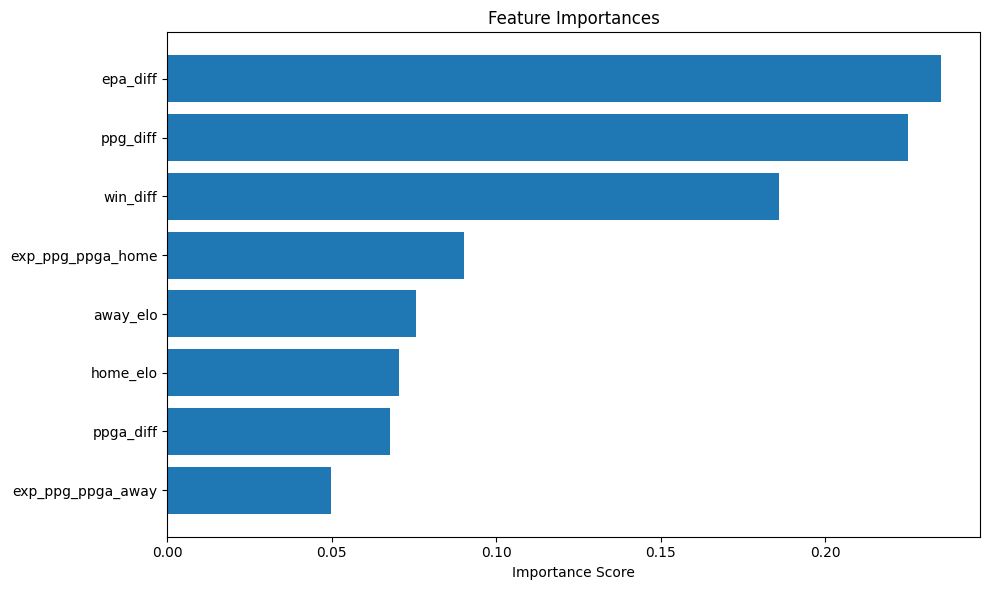

In [147]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from trained model
importances = final_model.feature_importances_
features = X.columns

# Sort and plot
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


### Points in a Game Model For Both Home/Away
-See if predicting points for both home/away is better to determine winner

In [84]:
# new_feats = ['home_points', 'away_points', 'home_epa_per_play', 'away_epa_per_play', 'home_points_allowed', 'away_points_allowed', 'ppg_diff', 'epa_diff', 'ppga_diff','home_elo', 'away_elo', 'win_diff']

home_feats = ['home_points', 'home_epa_per_play', 'away_points_allowed', 'home_elo']
away_feats = ['away_points', 'away_epa_per_play', 'home_points_allowed', 'away_elo']

In [85]:
X = check[home_feats]
y = check['home_score']

def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 13,
        'n_jobs': -1
    }

    cv = KFold(n_splits=3, shuffle=True, random_state=13)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))  # squared=False gives RMSE
        rmse_scores.append(rmse)

    avg_rmse = np.mean(rmse_scores)
    return avg_rmse  # Optuna will minimize this

# Run optimization
rf_study = optuna.create_study(direction='minimize')  # minimize RMSE
rf_study.optimize(rf_objective, n_trials=100)

# Train on full data with best params
best_rf_params = rf_study.best_params
best_rf_rmse = rf_study.best_value

best_rf_model = RandomForestRegressor(**best_rf_params)
best_rf_model.fit(X, y)

joblib.dump(best_rf_model, 'best_rf_home_points_model.pkl')

print("Best Random Forest Params:", best_rf_params)
print(f"Best RMSE: {best_rf_rmse:.4f}")

[I 2025-07-26 12:01:02,873] A new study created in memory with name: no-name-3ecd63b0-b7ba-40ad-a620-d3be7961c0ca
[I 2025-07-26 12:01:06,887] Trial 0 finished with value: 10.003349684154786 and parameters: {'n_estimators': 960, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 10.003349684154786.
[I 2025-07-26 12:01:10,364] Trial 1 finished with value: 10.294392997910512 and parameters: {'n_estimators': 611, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 10.003349684154786.
[I 2025-07-26 12:01:15,081] Trial 2 finished with value: 10.247749826181833 and parameters: {'n_estimators': 599, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 10.003349684154786.
[I 2025-07-26 12:01:15,990] Trial 3 finished with value: 10.018364204710311 a

Best Random Forest Params: {'n_estimators': 136, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}
Best RMSE: 9.8771


In [86]:
X = check[away_feats]
y = check['away_score']

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 13,
        'n_jobs': -1,
        'tree_method': 'hist'  # Use 'hist' for faster training
    }

    cv = KFold(n_splits=3, shuffle=True, random_state=13)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=25, verbose=False)

        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# Run Optuna optimization
xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgb_objective, n_trials=100)

# Best model training on full data
best_xgb_params = xgb_study.best_params
best_xgb_rmse = xgb_study.best_value

final_model = xgb.XGBRegressor(**best_xgb_params)
final_model.fit(X, y)

joblib.dump(final_model, 'best_xgb_away_points_model.pkl')

print("Best XGBoost Params:", best_xgb_params)
print(f"Best RMSE: {best_xgb_rmse:.4f}")

[I 2025-07-26 12:03:45,460] A new study created in memory with name: no-name-485832bc-9925-440f-9995-9fa901e1b9cf
[I 2025-07-26 12:03:47,011] Trial 0 finished with value: 9.941812987579729 and parameters: {'n_estimators': 306, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 9.941812987579729.
[I 2025-07-26 12:03:49,731] Trial 1 finished with value: 9.870758931942675 and parameters: {'n_estimators': 476, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 9.870758931942675.
[I 2025-07-26 12:03:50,281] Trial 2 finished with value: 9.916329555600276 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 9.870758931942675.
[I 2025-07-26 12:03:54,459] Trial 3 finished with value: 9.857395027257928 and p

Best Random Forest Params: {'n_estimators': 493, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Best RMSE: 9.6466


## Test to see which option is more accurate

In [90]:
import os

os.chdir("/Users/aidanbeilke/Desktop/Football Projects")

game_model = joblib.load('game_modeling/best_rf_model.pkl')
home_points_model = joblib.load('game_modeling/best_rf_home_points_model.pkl')
away_points_model = joblib.load('game_modeling/best_rf_away_points_model.pkl')


holdout_df['home_overall_winner'] = game_model.predict_proba(holdout_df[new_feats])[:, 1]
holdout_df['home_pred_points'] = home_points_model.predict(holdout_df[home_feats])
holdout_df['away_pred_points'] = away_points_model.predict(holdout_df[away_feats])

holdout_df['overall_home_win'] = np.where(holdout_df['home_overall_winner'] > .5, 1, 0)
holdout_df['points_home_win'] = np.where(holdout_df['home_pred_points'] > holdout_df['away_pred_points'], 1, 0)

### Analyze

In [88]:
match_pct = (holdout_df['overall_home_win'] == holdout_df['points_home_win']).mean()
game_model_acc = (holdout_df['overall_home_win'] == holdout_df['home_win']).mean()
point_model_acc = (holdout_df['points_home_win'] == holdout_df['home_win']).mean()

In [94]:
point_model_acc

0.64453125